In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sm
# import Bio
from sklearn.preprocessing import PolynomialFeatures
# #from scipy import interpolate
# from scipy.optimize import fsolve
import scipy.io
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from shapely.geometry import  LineString

In [2]:
class TriMatrix():
    '''
    большой массив с начальными данными по всем трём периодам
    '''
    def __init__(self, FilePath):
        with open(FilePath) as genoms_file:
            genoms = genoms_file.read()
        NASlist = []
        NamesAndSequence =genoms.split('>')
        for NameAndSeq in NamesAndSequence[1:]:
            NASlist.append(NameAndSeq.split('\n')[:-1])
        NASdict = {}
        for i in NASlist:
            if list(i[-1]) != list(i[0]):
                NASdict[i[0]] = list(i[-1])
        # датафрейм по 3 периодам сразу        
        self.df = pd.DataFrame.from_dict(NASdict, orient='index', 
                                         columns=range(1, len(NASlist[0][-1]) + 1))  
        self.origin = self.df.copy()
        
    def Separation(self):
        """
        Разделяет на 3 отдельных объекта
        """
        dict1 = {}
        dict2 = {}
        dict3 = {}
        for name in self.df.index:
            if 'cov1' in name:
                dict1[name] = self.df.loc[name]
            elif 'cov2' in name:
                dict2[name] = self.df.loc[name]
            elif 'cov3' in name:
                dict3[name] = self.df.loc[name]
        df1 = pd.DataFrame.from_dict(dict1, orient='index')
        df2 = pd.DataFrame.from_dict(dict2, orient='index')
        df3 = pd.DataFrame.from_dict(dict3, orient='index')
        m1 = Matrix()
        m1.df = df1
        m2 = Matrix()
        m2.df = df2
        m3 = Matrix()
        m3.df = df3
        return m1, m2, m3
        
class Matrix():
    def ColumnsCleaning(self, SiteGapsThreshold, SiteMonomorphThreshold):
        DropList = []
        '''
        Удаляет столбец если в нём слишком много пропусков
        '''
        for i in self.df.columns:
            if '-' in self.df.loc[:, i].value_counts():
                if self.df.loc[:, i].value_counts()['-']/self.df.shape[0]>=SiteGapsThreshold:
                    DropList.append(i)
        '''
        Удаляет столбец если в нём меньше чем определённое количество элементов,
        отличных от консенсуса
        '''
#         SiteMonomorphThreshold = 1-SiteMonomorphThreshold
        for i in self.df.columns:
            if len(self.df.loc[:,i].value_counts())>=2:
                if self.df.loc[:,i].value_counts().max()/self.df.shape[0]<=SiteMonomorphThreshold:
                    DropList.append(i)
            elif len(self.df.loc[:,i].value_counts())==1:
                DropList.append(i)
        DropList = list(set(DropList))
        self.df.drop(DropList, inplace=True, axis=1)
        
#         for i in self.df.columns:
#             # SiteMonomorphThreshold = 1-SiteMonomorphThreshold
#             if self.df.loc[:,i].value_counts().min()/self.df.shape[0]<=SiteMonomorphThreshold:
#                 DropList.append(i)
#         self.DropList = list(set(DropList))
#         self.df.drop(self.DropList, inplace=True, axis=1)

    def IndexCleaning(self, SeqGapsThreshold):
        """
        Удаляет последовательность если в ней слишком много пропусков
        """
        DropList = []
        for i in self.df.index:
            if '-' in self.df.loc[i, :].value_counts():
                if self.df.loc[i, :].value_counts()['-']/self.df.shape[1]>=SeqGapsThreshold:
                    DropList.append(i)
#         print(DropList)
        self.df.drop(DropList, inplace=True)

    def Binarization(self):
        """
        Преобразует в двоичный вид. 0 - более распространённый вариант. 1 - мутации
        """
        for i in self.df.columns:
            self.df.loc[self.df[i] == self.df.loc[:,i].value_counts().idxmax(), i] = 0
            self.df.loc[self.df[i] != self.df.loc[:,i].value_counts().idxmax(), i] = 1

In [3]:
def poly(x,y):
    poly = PolynomialFeatures(degree=4, include_bias=False)
    x=x
    y=y
    poly_features = poly.fit_transform(x.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y)
    y_predicted = poly_reg_model.predict(poly_features)
    return y_predicted

In [4]:
class Graphs():
    
    def __init__(self, m1, m2, m3, C=0, SearchIntersection=False):
        

        self.C=C
        
        self.df1 = m1.df
        self.df2 = m2.df
        self.df3 = m3.df
        
#         смотрим пересечения по периодам
        self.set1 = set(self.df1.columns)
        self.set2 = set(self.df2.columns)
        self.set3 = set(self.df3.columns)
        self.set12 = self.set1 & self.set2
        self.set13 = self.set1 & self.set3
        self.set23 = self.set2 & self.set3
        self.set123 = self.set1 & self.set2 & self.set3
        
        '''
        Тут, возможно, лучше заменить на то же что во втором подобном классе, 
        а то здесь это ужс какой-то
        '''
        CountDict1 = {}
        for name, values in self.df1.items():
            if len(self.df1[self.df1[name]==1]) != 0:
                CountDict1[name] = (len(self.df1[self.df1[name]==1]))/len(self.df1)
            else:
                CountDict1[name] = 0

        CountDict2 = {}
        for name, values in self.df2.items():
            if len(self.df2[self.df2[name] == 1]) != 0:
                CountDict2[name] = (len(self.df2[self.df2[name] == 1]))/len(self.df2)
            else:
                CountDict1[name] = 0
                
        CountDict3 = {}
        for name, values in self.df3.items():
            if len(self.df3[self.df3[name] == 1]) != 0:
                CountDict3[name] = (len(self.df3[self.df3[name] == 1]))/len(self.df3)
            else:
                CountDict1[name] = 0
        
        
        
        self.Dict123 = {1:CountDict1, 2:CountDict2, 3:CountDict3}

        self.Frame123 = pd.DataFrame(self.Dict123)#.dropna(axis='index')
        self.Frame123 = self.Frame123.loc[list(self.set123)]
        self.Frame123.loc[:,'mean'] = self.Frame123.mean(axis=1)
        
        
        self.new_ids = list(self.Frame123.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.Frame123.sort_values('mean', axis=0, ascending=True)
        self.logFrame = -1*np.log(self.SortFrame)
        
        self.SearchIntersection = SearchIntersection
        
        self.x=np.arange(1,len(self.new_ids)+1)
        self.y=(self.logFrame.loc[:,1].to_numpy())
        self.y2=(self.logFrame.loc[:,2].to_numpy())
        self.y3=(self.logFrame.loc[:,3].to_numpy())
        if self.SearchIntersection:    
            line_1 = LineString(np.column_stack((self.x, poly(self.x,self.y))))
            line_2 = LineString(np.column_stack((self.x, poly(self.x,self.y2))))
            line_3 = LineString(np.column_stack((self.x, poly(self.x,self.y3))))
            intersection12 = line_1.intersection(line_2)
            intersection13 = line_1.intersection(line_3)
            intersection32 = line_3.intersection(line_2)
            self.x0 = (intersection12.xy[0][0]+intersection13.xy[0][0]+intersection32.xy[0][0])/3
            self.C = (intersection12.xy[1][0]+intersection13.xy[1][0]+intersection32.xy[1][0])/3
            
        self.table_poly_s = pd.DataFrame([poly(self.x,self.y),
                       poly(self.x,self.y2),poly(self.x,self.y3)],
             columns=self.SortFrame.index, index=range(1,4)).T.sort_index().T-self.C
        self.table_s = self.logFrame.sort_index().T.loc[1:3,:]-self.C
        
        


    def PrintL(self):
        '''
        Показывает сколько осталось сайтов и сколько пересечений по 
        оставшимся сайтам между периодами
        '''
        texts = ['L1', 'L2', 'L3', 'L12', 'L13', 'L23', 'L123']
        sets = [self.set1, self.set2, self.set3, self.set12, self.set13, self.set23, self.set123]
        for i in range(7):
            print(texts[i],'=',str(len(sets[i])))
            


    def sMeasureLine(self, Mean=False, 
                     axis = 'unvalueAxis'):
        """
        строит график зависимости beta*s от сайтов
        """
        
        plt.figure(figsize=(6,3), dpi = 300)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta s_i$')
        
        if axis == 'valueAxis':    
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,1].to_numpy()-self.C),
                     'r.-',label='1')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,2].to_numpy()-self.C),
                     'g.-',label='2')
            plt.plot([f"{idx}" for idx in self.new_ids], 
                     (self.logFrame.loc[:,3].to_numpy()-self.C),
                     'k.-',label='3')
            if Mean:
                plt.plot([f"{idx}" for idx in self.new_ids], 
                         (self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean')
            
        elif axis =='unvalueAxis':
            plt.plot(self.x, (self.y-self.C),'r.-',label='1')
            plt.plot(self.x, (self.y2-self.C),'g.-',label='2')
            plt.plot(self.x, (self.y3-self.C),'k.-',label='3')
            if Mean:
                plt.plot(self.x,(self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',label='mean')
         
        plt.legend()
        if self.SearchIntersection:
            plt.plot(self.x0,0,'ob')
            ax = plt.gca()
            ax.axhline(y=0, color='k',ls=':')   
    
    def PolyS(self):
        plt.figure(figsize=(6,3), dpi = 300)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta s_i$')        
        plt.plot(self.x, self.y,'r.-',alpha=0.2)
        plt.plot(self.x, poly(self.x,self.y), c="r")
        plt.plot(self.x, self.y2,'g.-',alpha=0.2)
        plt.plot(self.x, poly(self.x,self.y2), c="g")
        plt.plot(self.x, self.y3,'k.-',alpha=0.2)
        plt.plot(self.x, poly(self.x,self.y3), "k")
        if self.SearchIntersection:
            plt.plot(self.x0,self.C,'ob')

    def sMeasureHist(self, Interpol=False, figsize=(16,4)):
        """
        Гистограмма значений s для каждого сайта
        """
        if Interpol==False:
            for j in [1,2,3]:
                plt.figure(figsize=figsize, dpi=300)
#                 plt.bar(list(self.Frame123.T.columns), 
#                         [-i-self.C for i in np.log(self.Frame123.T.loc[[j],:].values[0])],
#                         bottom=None)
                plt.bar(list(self.Frame123.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None,label='real')
                plt.ylabel('$\\beta s_i$')
                plt.xlabel('genomic site number')
                ax = plt.gca()
                ax.axhline(y=0, color='k',ls='-')        
        else:
            for j in [1,2,3]:
                plt.figure(figsize=figsize, dpi=300)
                plt.bar(np.array(self.Frame123.T.columns), 
                        [i for i in (self.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
                plt.bar(list(self.Frame123.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
                ax = plt.gca()
                ax.axhline(y=0, color='k',ls='-')
                plt.legend()
                plt.ylabel('$\\beta s_i$')
                plt.xlabel('genomic site number')

In [5]:
realData = 'C:/Users/sPIDERman/period123.fas'
SeqGapsThreshold=0.005
SiteGapsThreshold=0.05
SiteMonomorphThreshold=0.015

In [6]:
test=TriMatrix(realData)
m1,m2,m3=test.Separation()
for m in [m1,m2,m3]:
    m.IndexCleaning(SeqGapsThreshold)
    m.ColumnsCleaning(SiteGapsThreshold,SiteMonomorphThreshold)
    m.Binarization()

In [7]:
tGraph=Graphs(m1,m2,m3,C=6.05)
tGraph.Frame123.index

Int64Index([129, 130, 132, 421, 166, 73, 657, 149, 54, 698, 538, 251, 414], dtype='int64')

In [8]:
# смотрим сколько еденичек на каждом оставшемся сайте
for i in tGraph.df1.columns:
    print(tGraph.df1.loc[:,i].value_counts())

0    945
1      2
Name: 40, dtype: int64
0    941
1      6
Name: 54, dtype: int64
0    946
1      1
Name: 64, dtype: int64
0    946
1      1
Name: 73, dtype: int64
0    946
1      1
Name: 75, dtype: int64
0    946
1      1
Name: 106, dtype: int64
0    945
1      2
Name: 129, dtype: int64
0    942
1      5
Name: 130, dtype: int64
0    940
1      7
Name: 132, dtype: int64
0    945
1      2
Name: 134, dtype: int64
0    946
1      1
Name: 146, dtype: int64
0    946
1      1
Name: 149, dtype: int64
0    946
1      1
Name: 166, dtype: int64
0    946
1      1
Name: 177, dtype: int64
0    946
1      1
Name: 192, dtype: int64
0    946
1      1
Name: 209, dtype: int64
0    945
1      2
Name: 210, dtype: int64
0    945
1      2
Name: 211, dtype: int64
0    943
1      4
Name: 221, dtype: int64
0    940
1      7
Name: 223, dtype: int64
0    946
1      1
Name: 249, dtype: int64
0    946
1      1
Name: 251, dtype: int64
0    943
1      4
Name: 257, dtype: int64
0    946
1      1
Name: 258, dtype: int

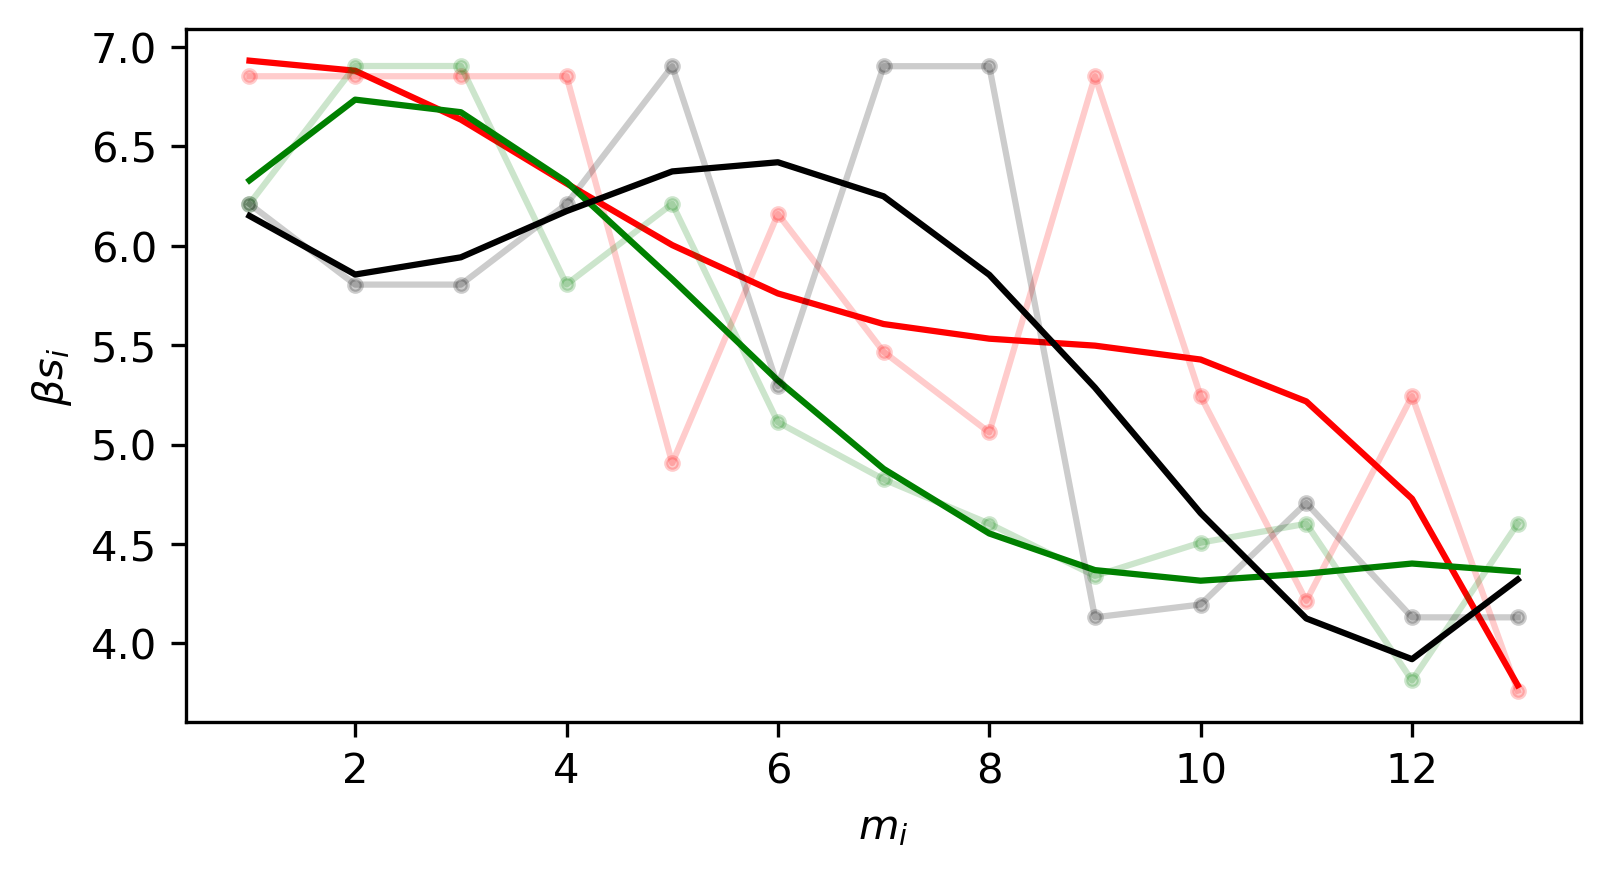

In [9]:
tGraph.PolyS()

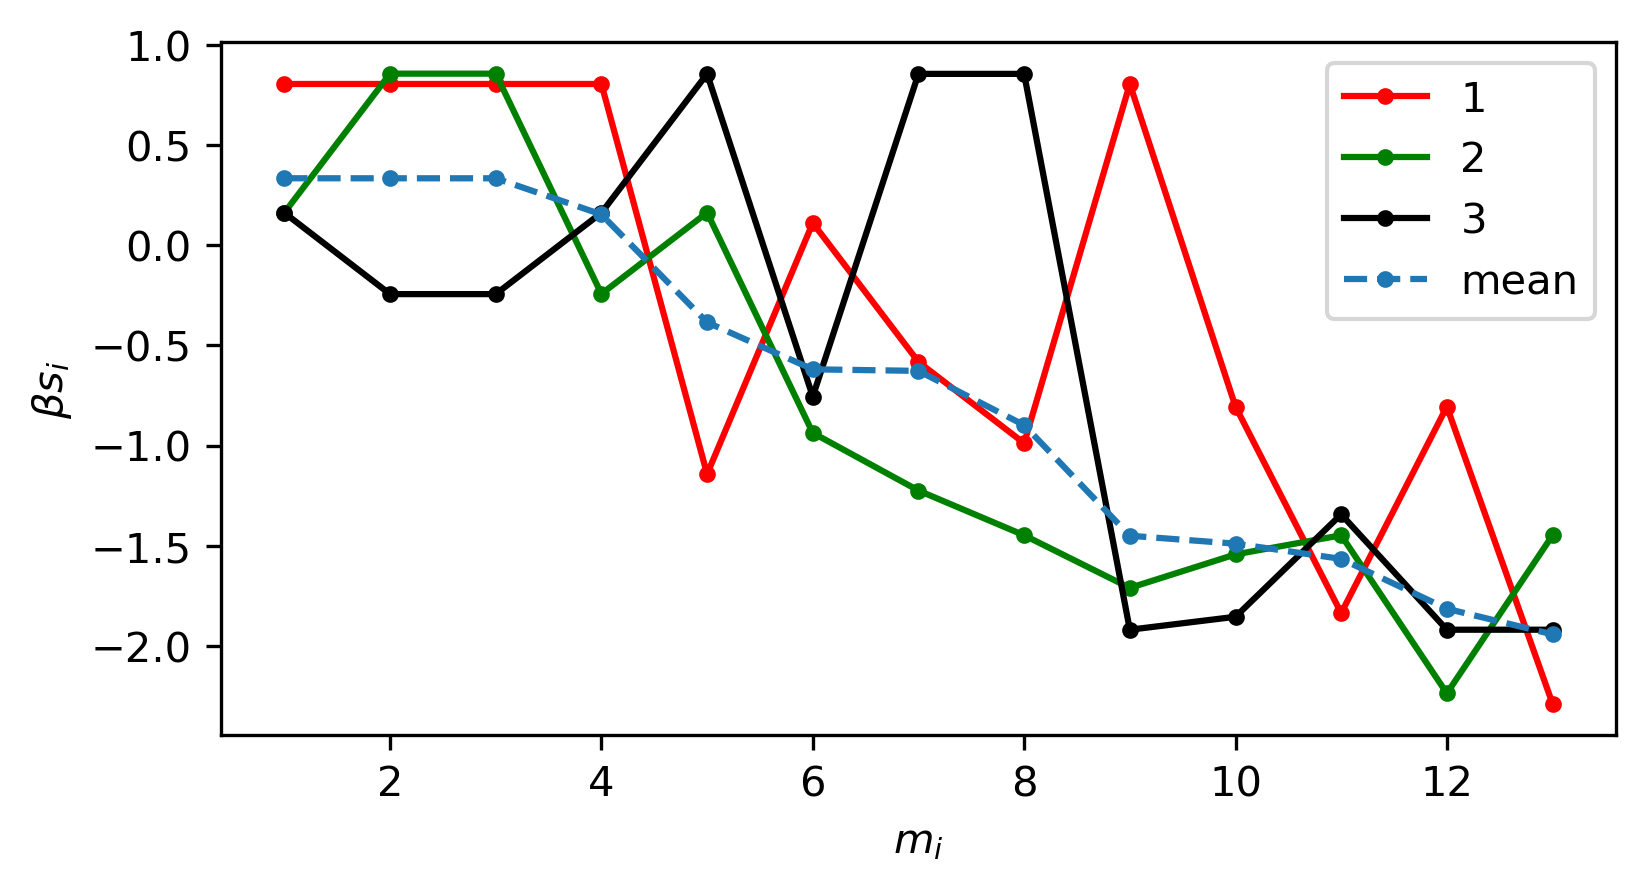

In [89]:
tGraph.sMeasureLine(Mean=True, axis='unvalueAxis')

[251, 166, 73, 657, 132, 129, 698, 54, 421]


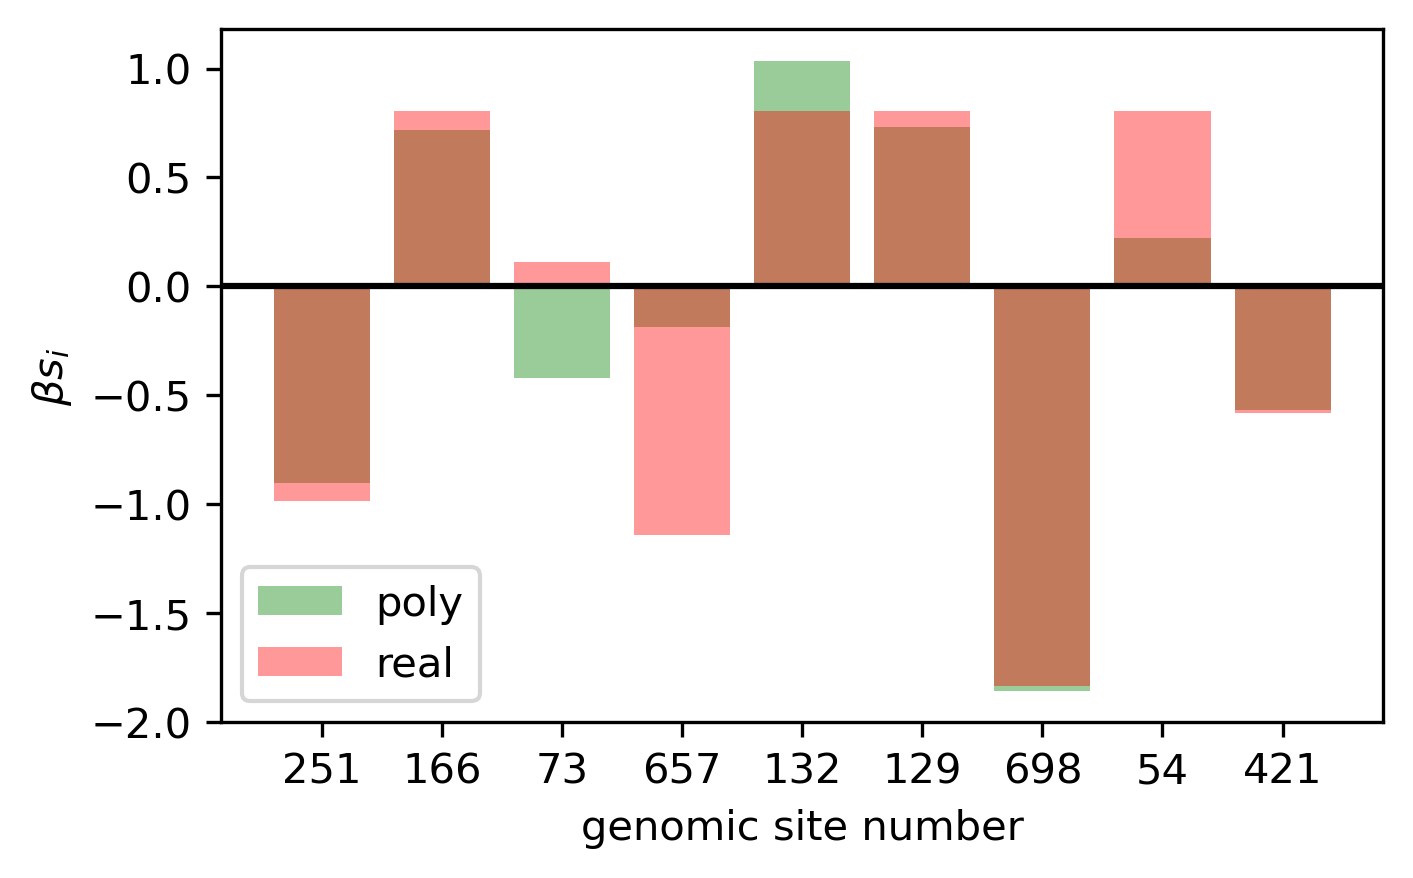

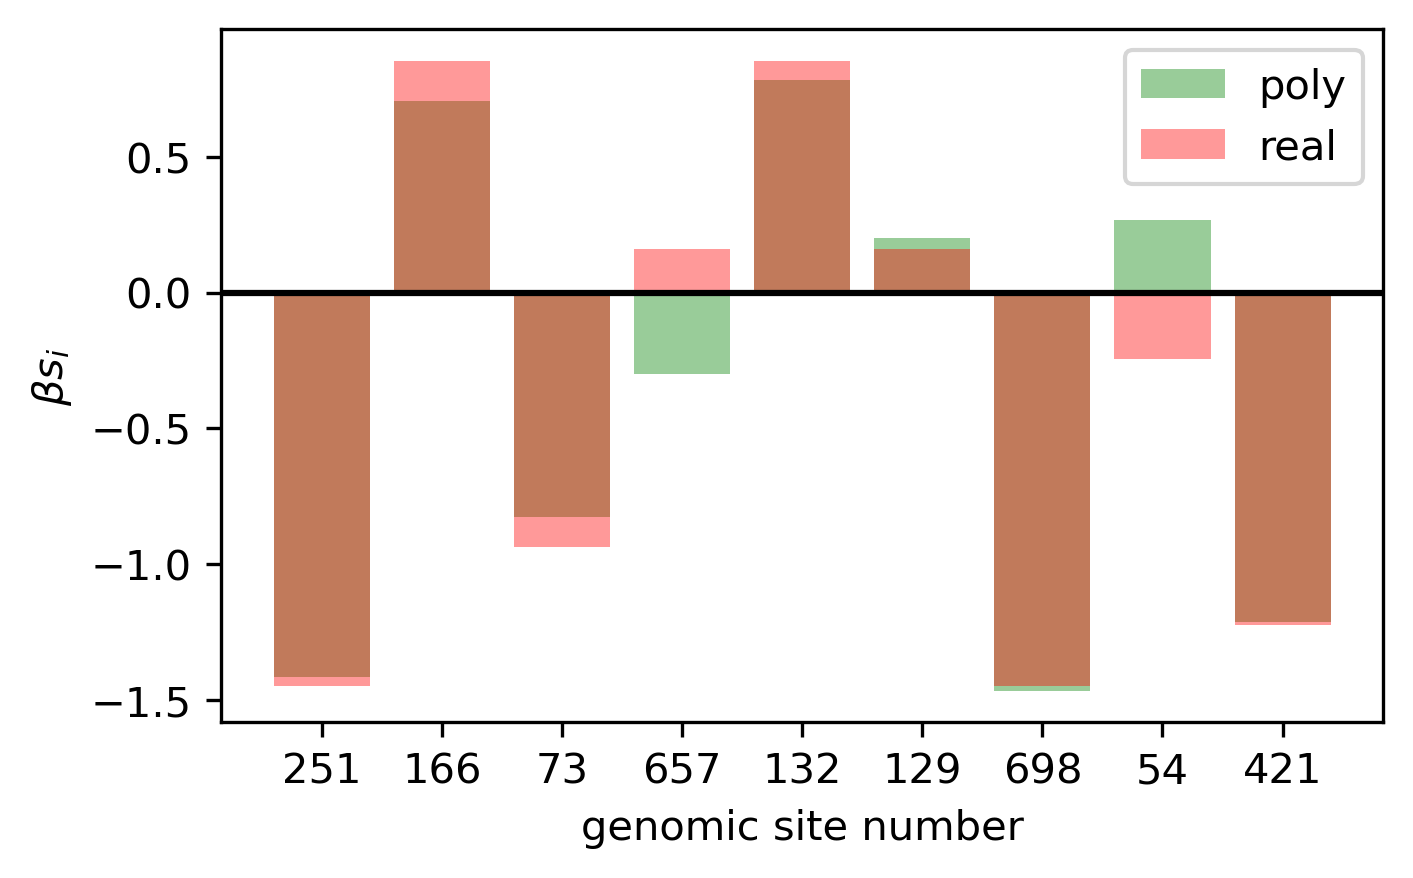

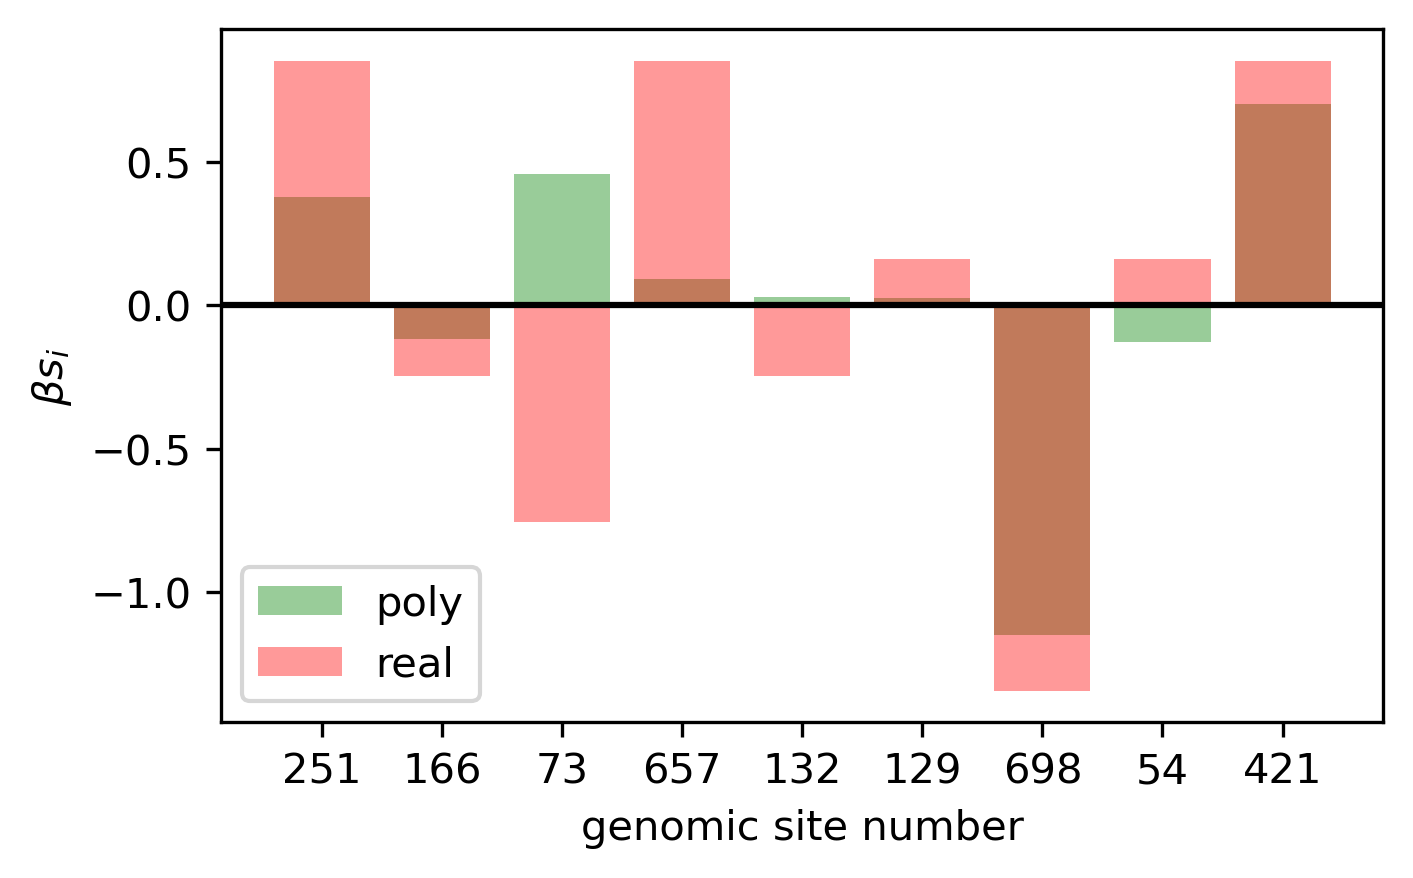

In [34]:
indxs=tGraph.new_ids
print(indxs)
for j in [1,2,3]:
    plt.figure(figsize=(5,3), dpi=300)
    plt.bar([f"{idx}" for idx in tGraph.new_ids], 
                        [i for i in (tGraph.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
    plt.bar([f"{idx}" for idx in tGraph.new_ids], 
                        [i for i in (tGraph.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
    ax = plt.gca()
    ax.axhline(y=0, color='k',ls='-')
    plt.legend()
    plt.ylabel('$\\beta s_i$')
    plt.xlabel('genomic site number')

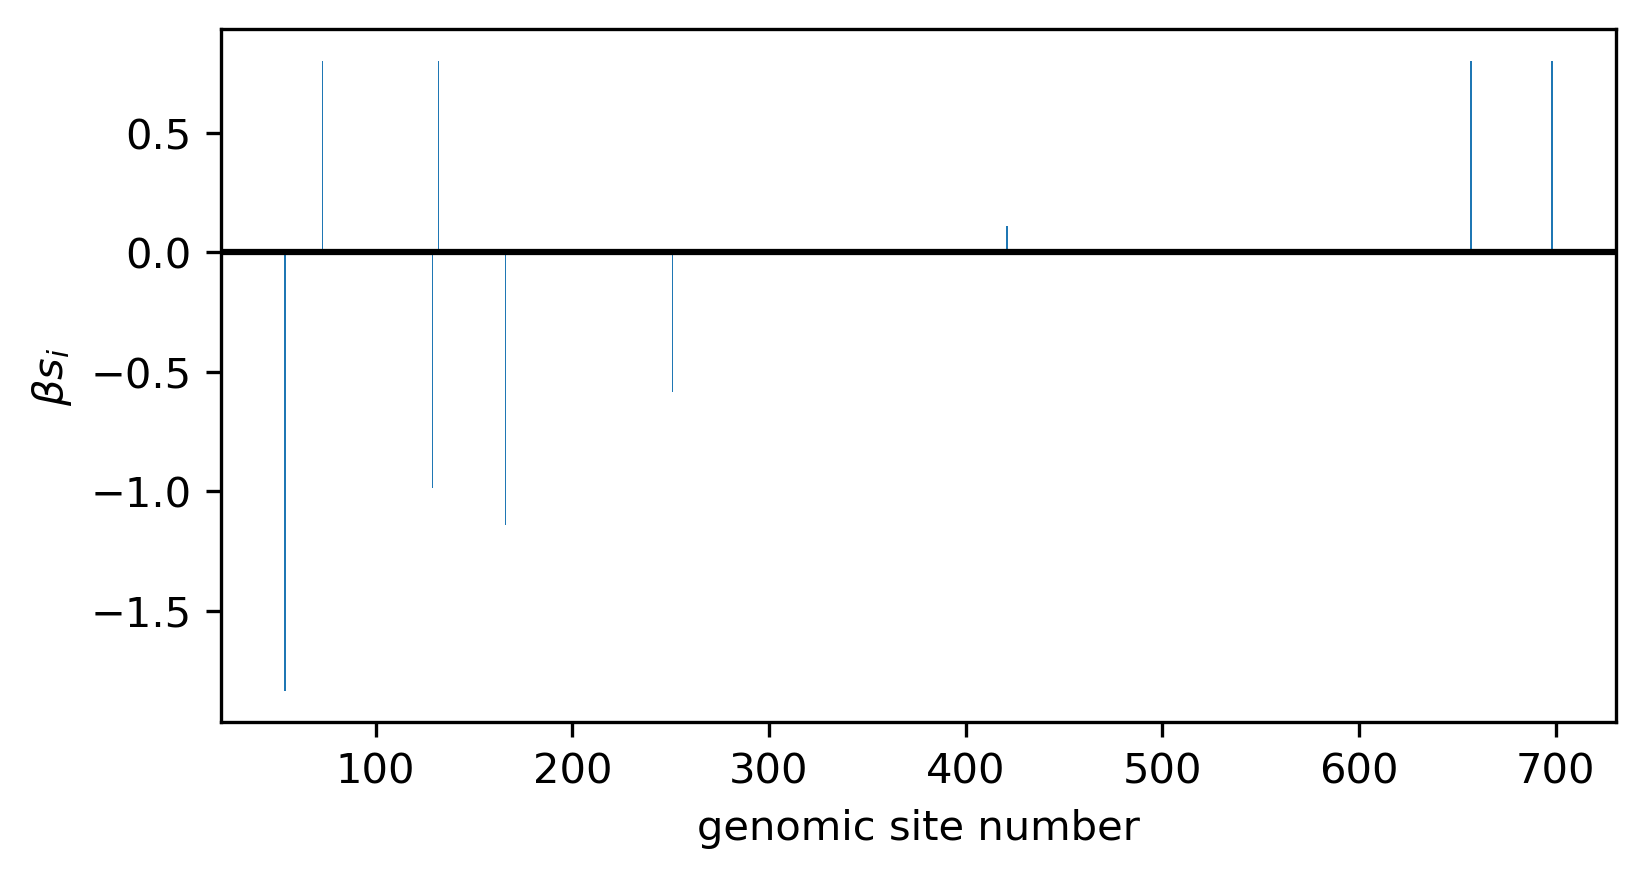

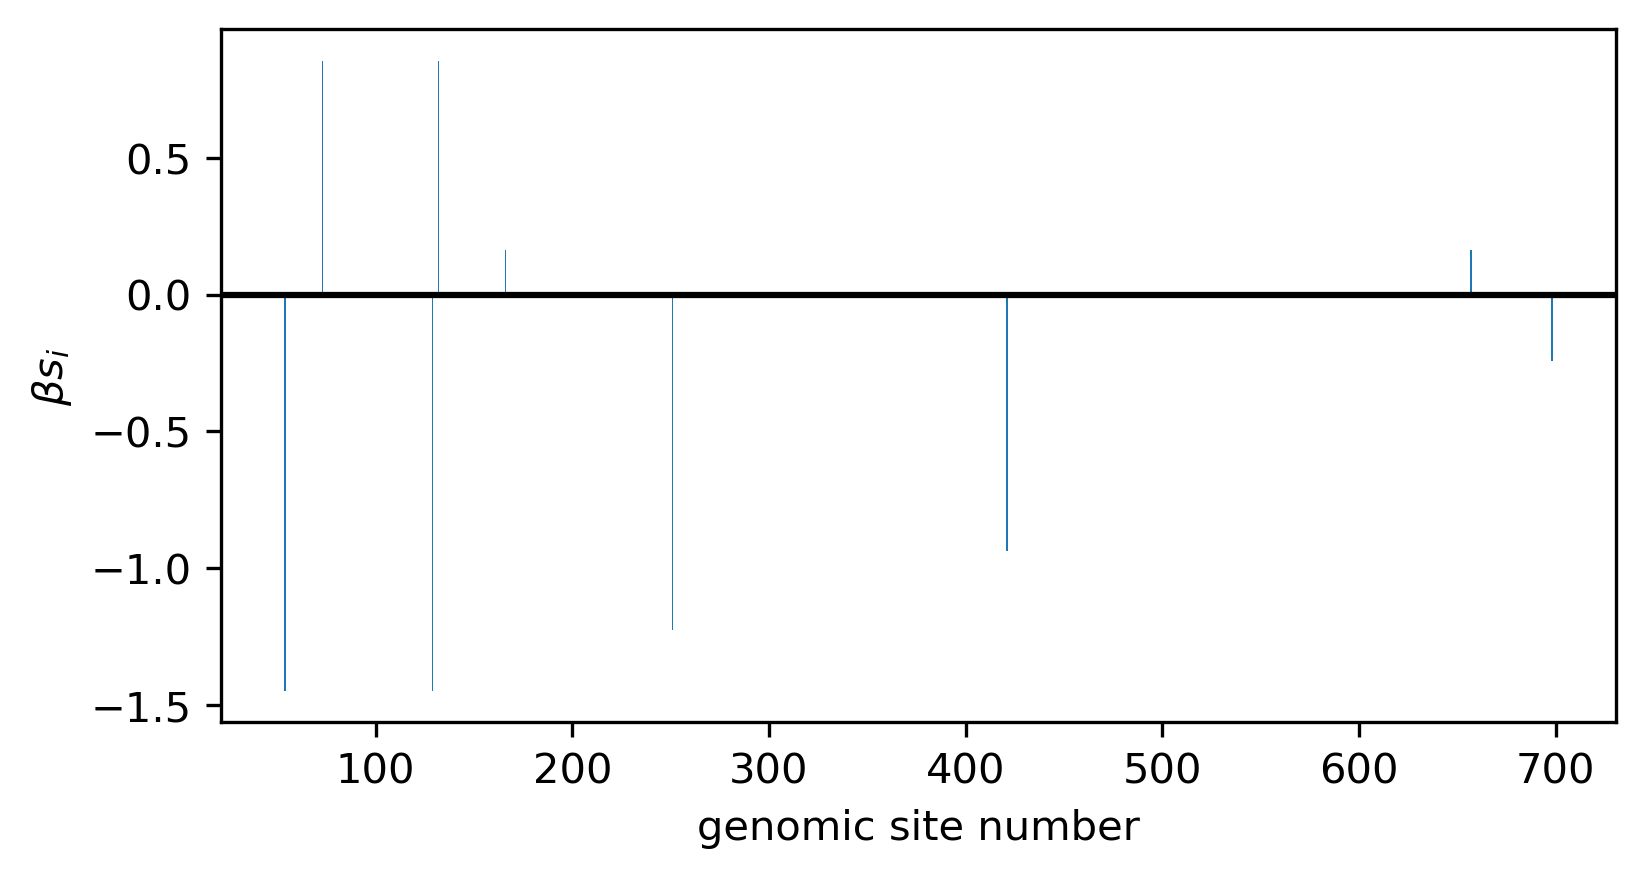

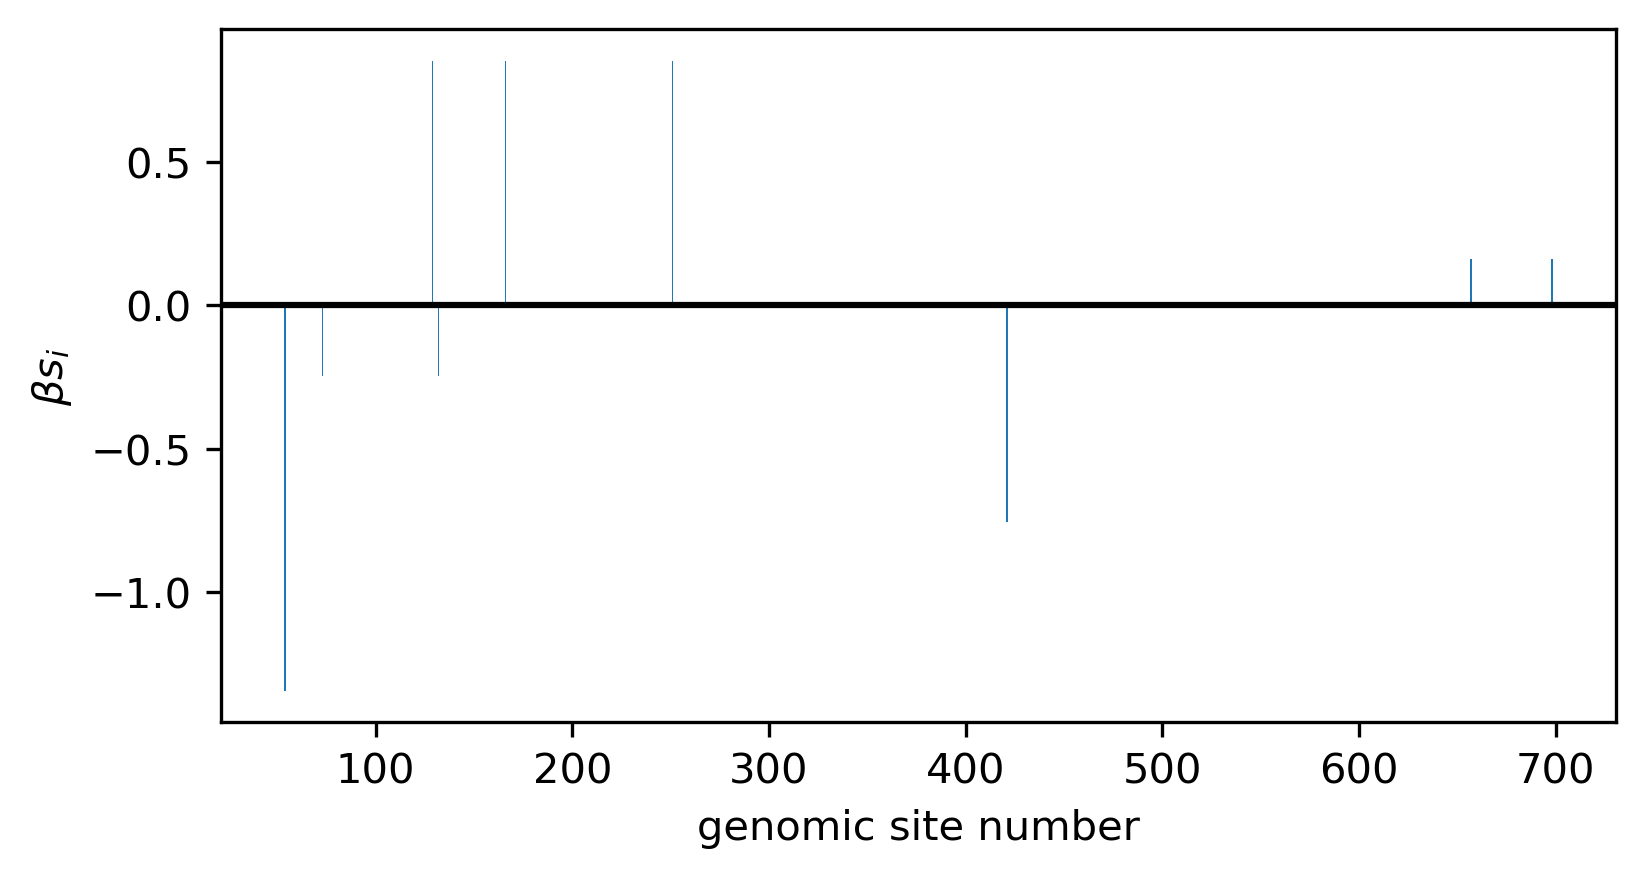

In [35]:
tGraph.sMeasureHist(figsize=(6,3))

In [36]:
FileName = 'C:/Users/sPIDERman/Desktop/proecttest/SimData100.mat'


In [37]:
graph = GraphsForSim2(FileName,'Data',SearchIntersection=True)

In [38]:
graph.Frame123

,1,2,3,mean
1,0.19123,0.27853,0.34100,0.270253
2,0.04266,0.02906,0.02727,0.032997
3,0.16207,0.21325,0.25278,0.209367
4,0.18079,0.25059,0.31591,0.249097
5,0.10363,0.10877,0.10458,0.105660
...,...,...,...,...
96,0.09149,0.07227,0.07758,0.080447
97,0.23592,0.35873,0.44657,0.347073
98,0.08815,0.08971,0.08256,0.086807
99,0.08069,0.06293,0.05110,0.064907


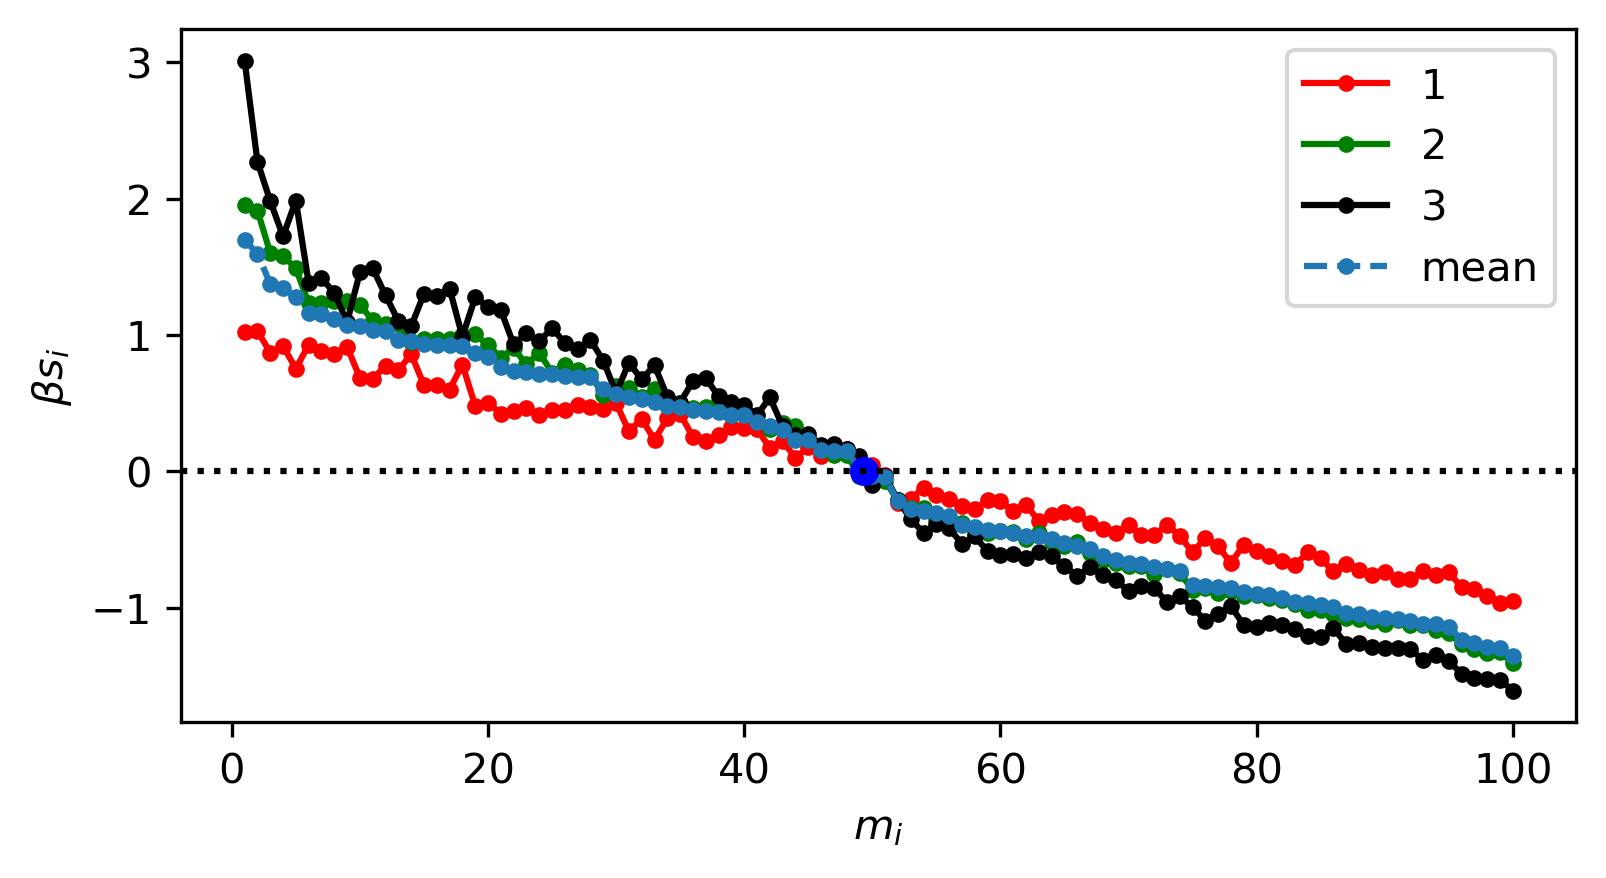

In [39]:
graph.sMeasureLine(axis='unvalueAxis',Mean=True)


In [40]:
graph.table_s.loc[3].sort_values() 

94   -1.607666
57   -1.527115
56   -1.524213
12   -1.513413
97   -1.484783
        ...   
67    1.725331
93    1.983487
50    1.987085
39    2.273086
71    3.013394
Name: 3, Length: 100, dtype: float64

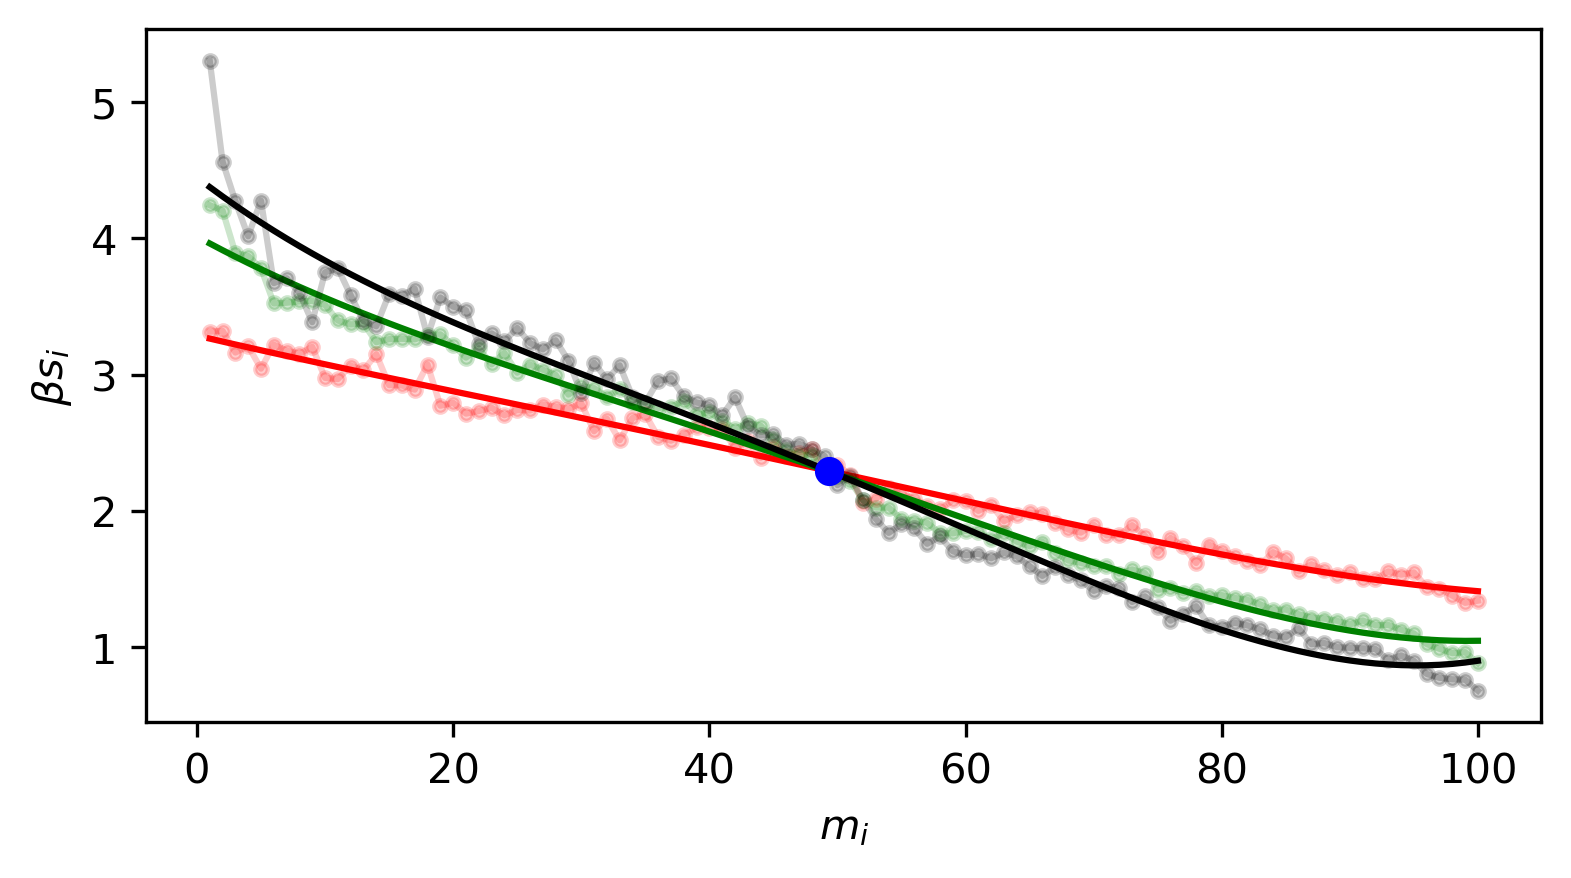

In [41]:
graph.PolyS()

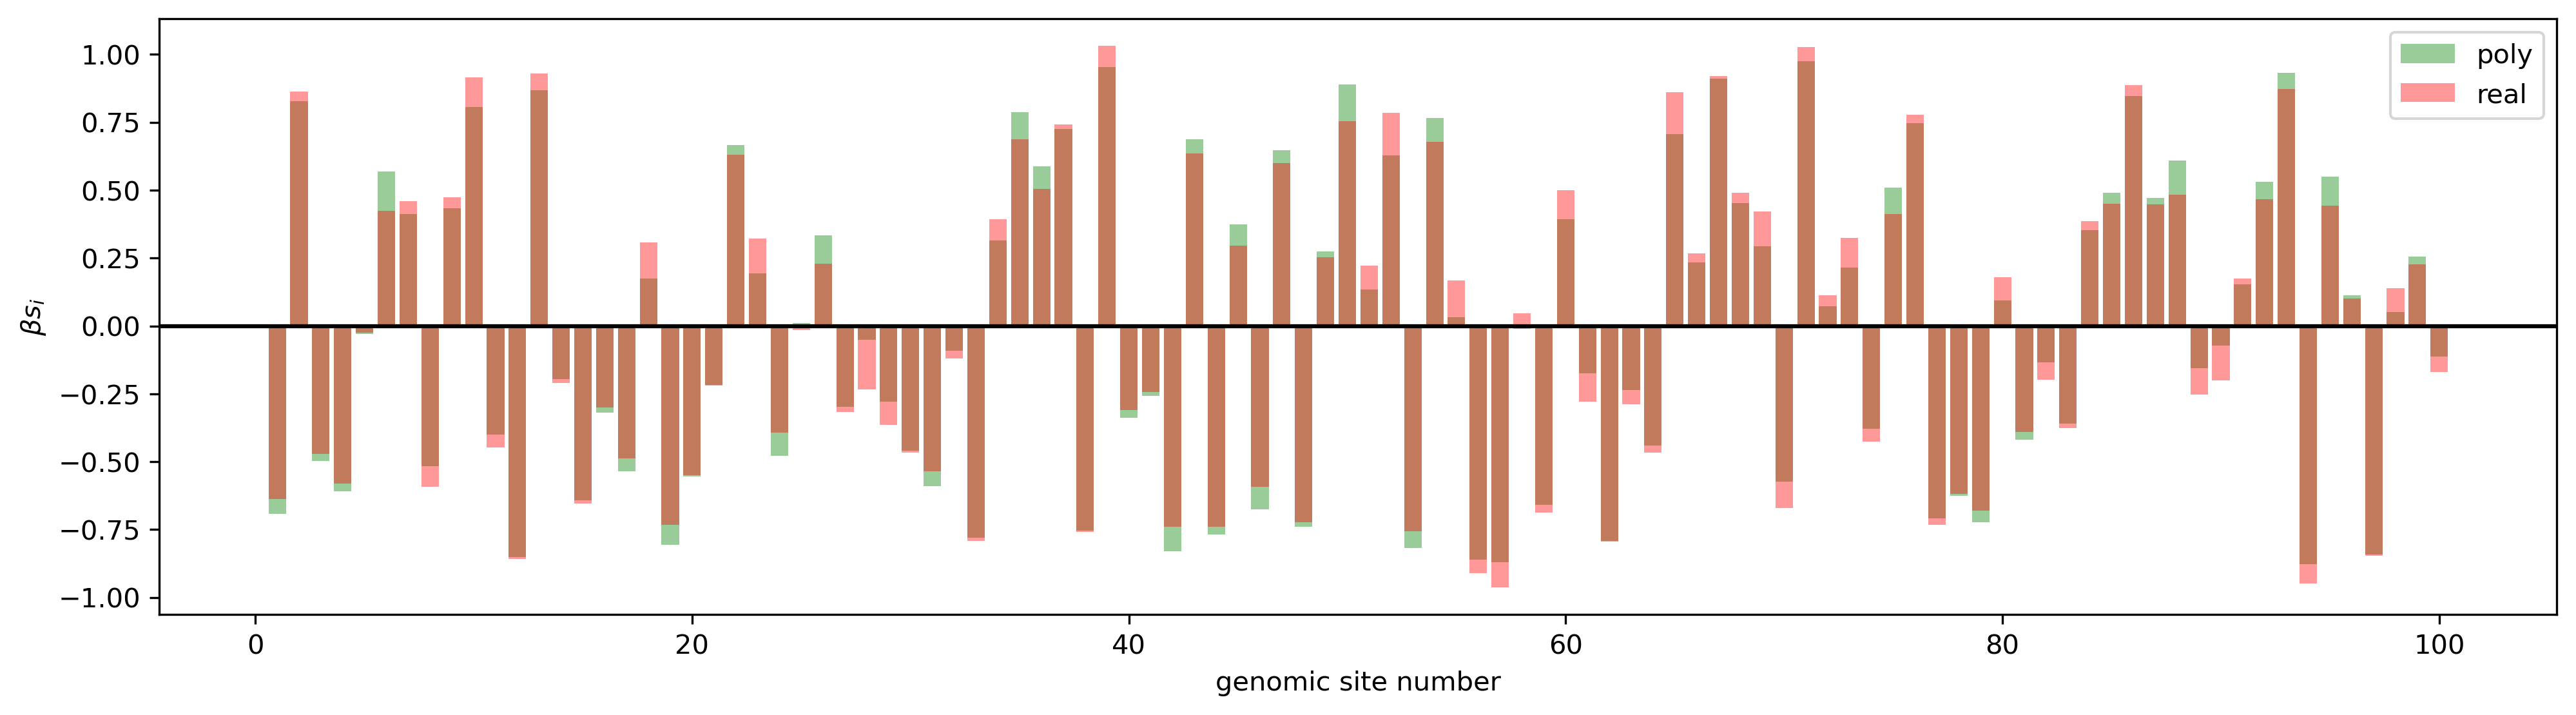

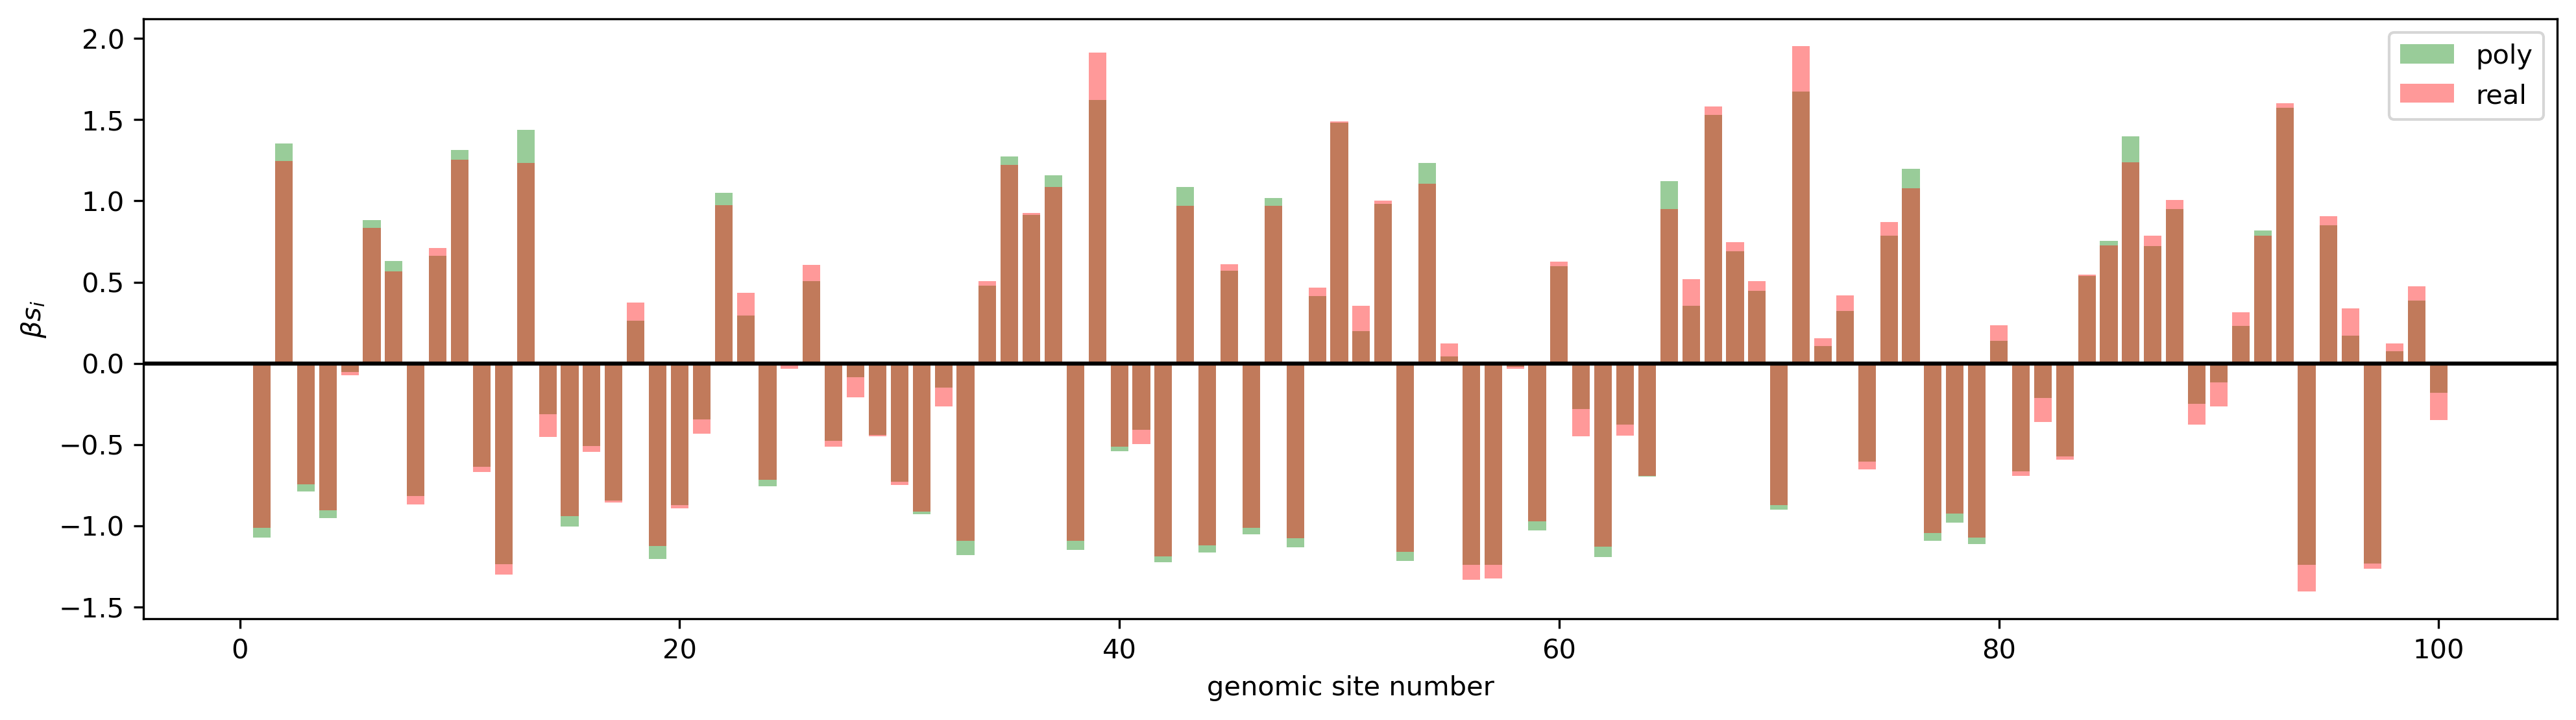

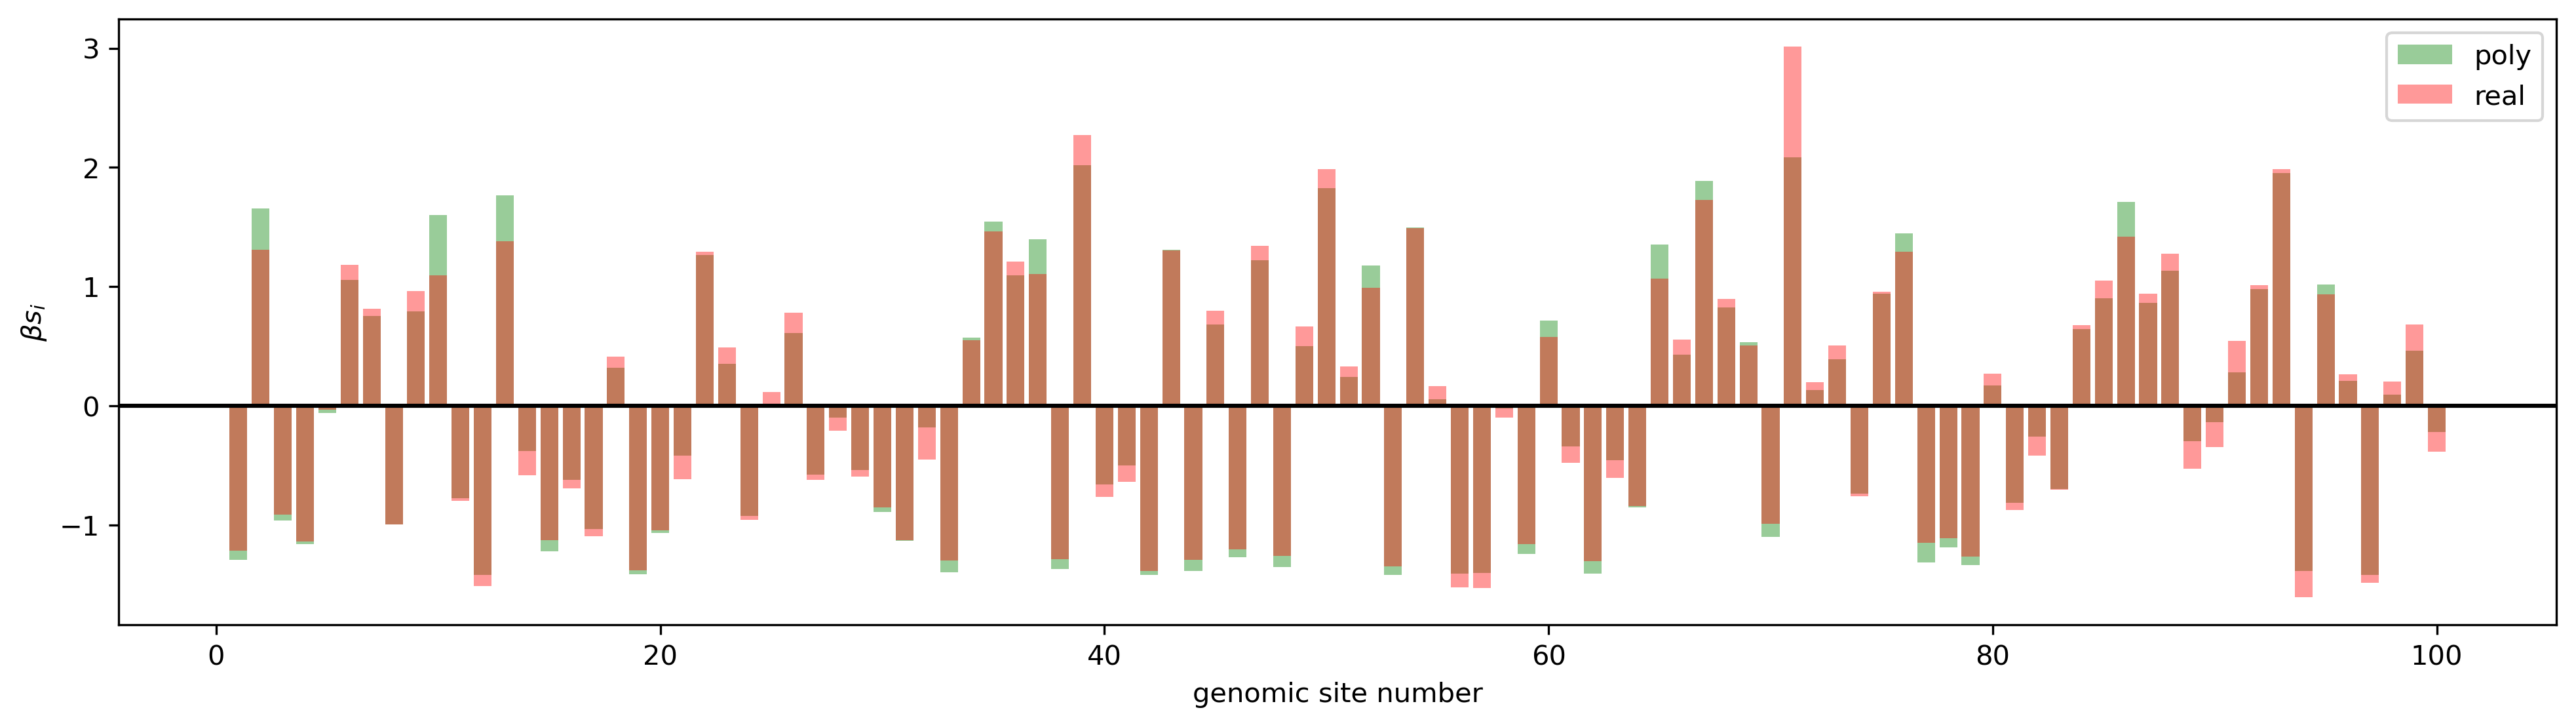

In [42]:
graph.sMeasureHist(Interpol=True)

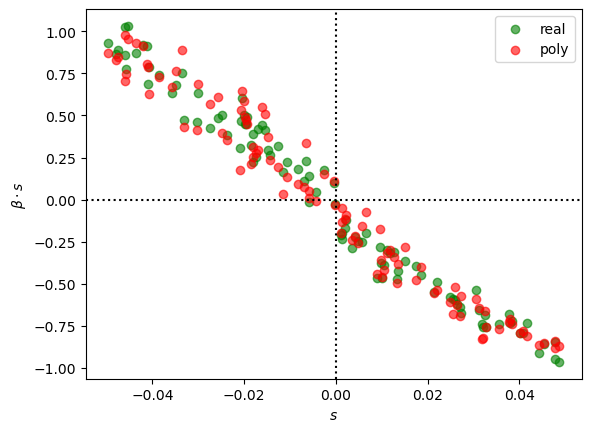

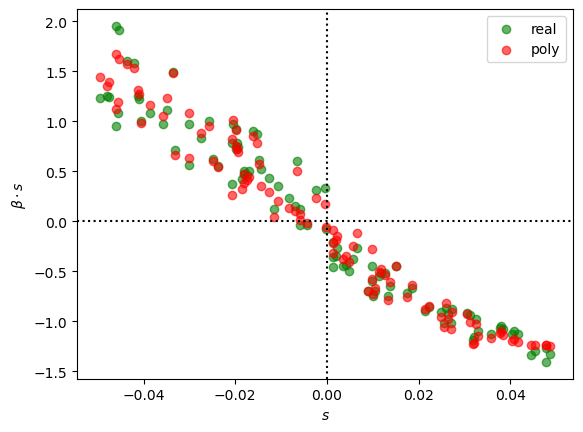

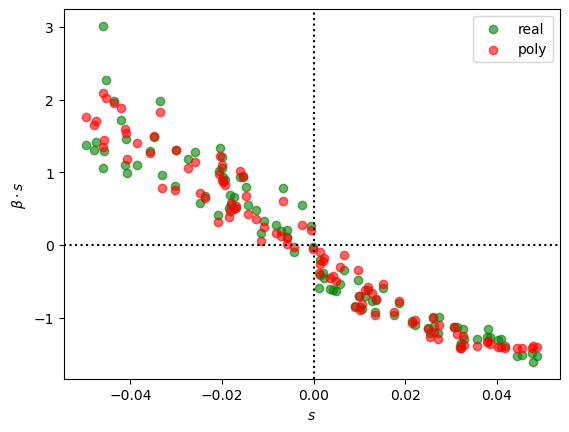

In [43]:
graph.beta_s()

In [24]:
mat = scipy.io.loadmat('C:/Users/sPIDERman/Desktop/proecttest/SimData100.mat')
sDict={}
mat['S_'][0].shape
# real_s = pd.DataFrame(mat['S_'][0][0],columns=range(1,len(mat['S_'][0][0][0])+1))
# real_s

(100,)

In [25]:
graph.table_s

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,-0.744389,1.257601,-1.102185,-0.979892,0.327072,0.306453,0.415708,-1.057360,0.221265,0.891910,...,0.460604,1.029188,1.026190,-1.059222,-0.020184,-0.228283,-1.203761,-0.149236,0.438736,-0.376438
2,-1.146110,2.925307,-1.549070,-1.254603,0.764286,1.331999,1.434653,-1.470375,0.768905,0.536545,...,1.020219,2.987183,2.742986,-1.528109,-0.099012,0.741506,-1.692186,-0.542302,1.853724,-0.328163
3,-1.269787,5.045571,-1.625829,-1.463198,1.412380,2.603224,2.083740,-1.581367,1.331999,0.120736,...,1.655547,4.129280,4.891420,-1.787820,-0.178382,1.499792,-1.819103,-0.703291,4.198273,-0.553468


In [26]:
# real_s.

In [26]:
# xsp = np.array([i for i in mat['S_'][0][9][0]])
xsp = real_s.to_numpy()
ysp = graph.table_poly_s.loc[2,:].to_numpy()
xs = real_s.to_numpy()
ys = graph.table_s.loc[2,:].to_numpy()

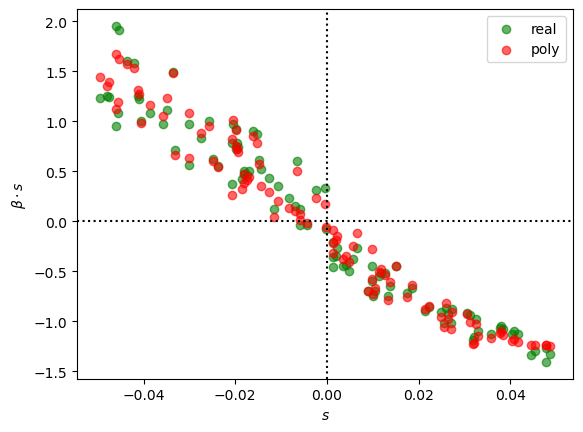

In [27]:
xsp = real_s.to_numpy()
ysp = graph.table_poly_s.loc[2,:].to_numpy()
xs = real_s.to_numpy()
ys = graph.table_s.loc[2,:].to_numpy()
plt.scatter(xs,ys,color='g', label='real',alpha=0.6)
plt.scatter(xsp,ysp,color='r', label='poly',alpha=0.6)
ax = plt.gca()
ax.axhline(y=0, color='k',ls=':')  
ax.axvline(x=0, color='k',ls=':')
plt.xlabel('$s$')
plt.ylabel('$\\beta \\cdot s$')
plt.legend()

In [18]:
graph.table_poly_s

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,-0.726834,0.751426,-0.584007,-0.668377,-0.087478,0.488402,0.356670,-0.599606,0.373229,0.726647,...,0.115179,0.455103,0.891105,-1.034339,0.471657,0.072416,-0.902808,0.005598,0.215209,-0.183102
2,-1.064835,1.190430,-0.862001,-0.974371,-0.148070,0.803448,0.644226,-0.881869,0.667759,1.134612,...,0.219800,0.768339,1.614413,-1.441928,0.786051,0.139668,-1.318676,0.016572,0.406777,-0.306914
3,-1.246909,1.396772,-1.016427,-1.137332,-0.198198,0.981668,0.839802,-1.036903,0.865267,1.317716,...,0.291818,0.957027,2.069214,-1.609711,0.969855,0.183470,-1.534209,0.018246,0.543422,-0.399574


In [19]:
graph.table_s

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
1,-0.701399,0.798816,-0.535951,-0.645258,-0.088749,0.360002,0.394289,-0.658282,0.410055,0.849542,...,0.110368,0.402298,0.808000,-1.012136,0.378614,0.035848,-0.911415,0.073038,0.161463,-0.233746
2,-1.077448,1.182715,-0.810388,-0.971740,-0.137158,0.770391,0.499424,-0.932470,0.643661,1.187199,...,0.247877,0.720831,1.538997,-1.470958,0.839482,0.271669,-1.330492,0.055495,0.410055,-0.412932
3,-1.279805,1.246290,-0.980442,-1.203380,-0.097875,1.118413,0.748754,-1.059005,0.898048,1.030434,...,0.479297,0.947939,1.918751,-1.672402,0.867708,0.200768,-1.549519,0.138552,0.618293,-0.451264


In [20]:
line_1 = LineString(np.column_stack((x, poly(x,y))))
line_2 = LineString(np.column_stack((x, poly(x,y2))))
line_3 = LineString(np.column_stack((x, poly(x,y3))))
intersection12 = line_1.intersection(line_2)
intersection13 = line_1.intersection(line_3)
intersection32 = line_3.intersection(line_2)
x0 = (intersection12.xy[0][0]+intersection13.xy[0][0]+intersection32.xy[0][0])/3
y0 = (intersection12.xy[1][0]+intersection13.xy[1][0]+intersection32.xy[1][0])/3

NameError: name 'x' is not defined

In [ ]:
x0 = (intersection12.xy[0][0]+intersection13.xy[0][0]+intersection32.xy[0][0])/3
y0 = (intersection12.xy[1][0]+intersection13.xy[1][0]+intersection32.xy[1][0])/3
y0

In [21]:
x0,y0=intersection32.xy
float(y0[0])

NameError: name 'intersection32' is not defined

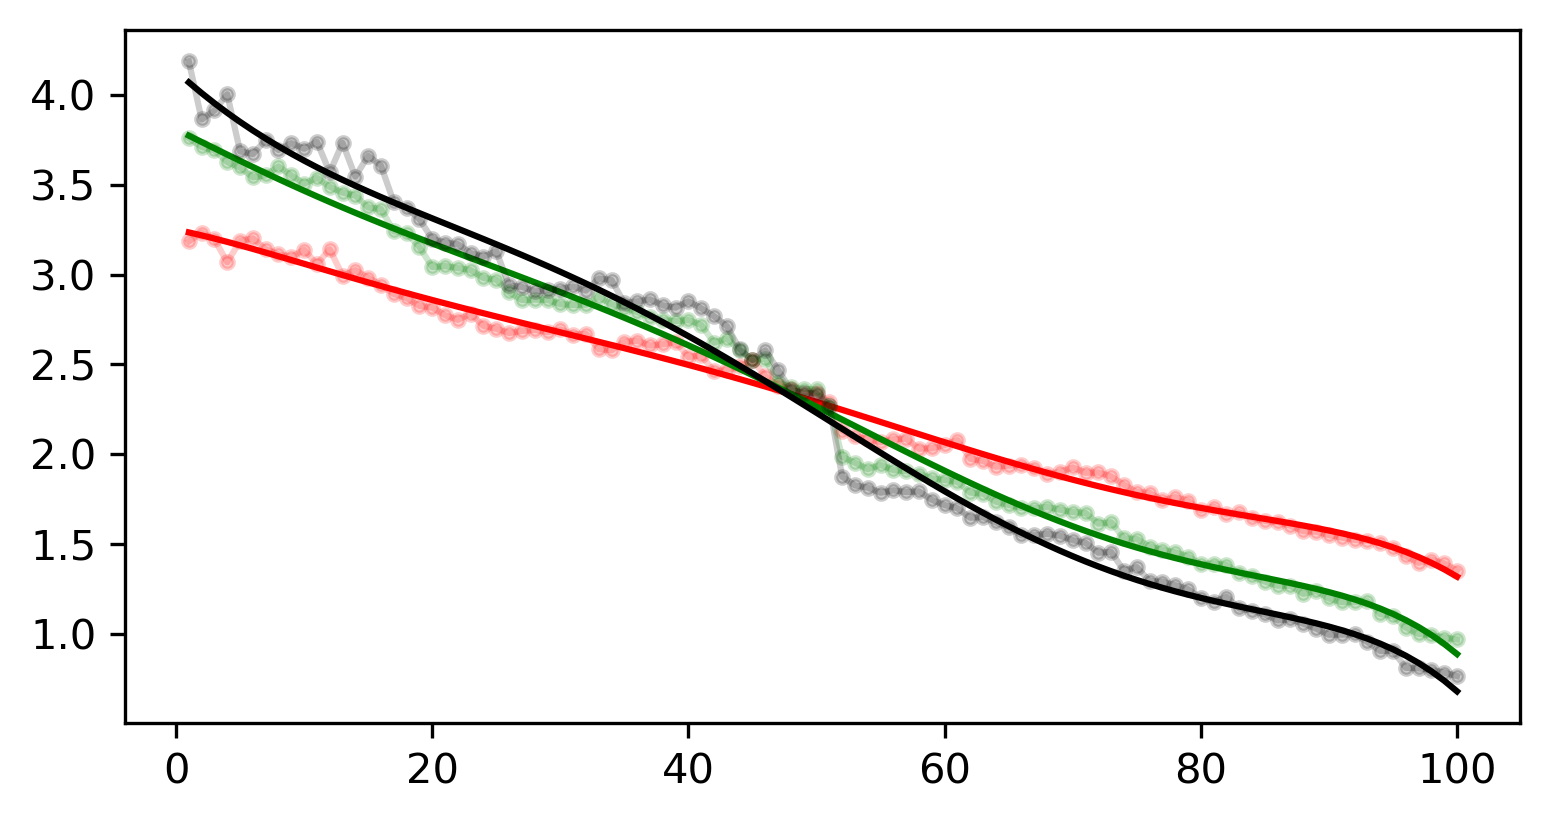

In [108]:
plt.figure(figsize=(6,3), dpi = 300)
# plt.ylim(0.5,4.5)
plt.plot(x, y,'r.-',alpha=0.2)
plt.plot(x, poly(x,y), c="r")
plt.plot(x2, y2,'g.-',alpha=0.2)
plt.plot(x2, poly(x,y2), c="g")
plt.plot(x3, y3,'k.-',alpha=0.2)
plt.plot(x3, poly(x,y3), "k")
# plt.xlim(45,52)
# plt.ylim(2,2.6)

In [70]:
poly = PolynomialFeatures(degree=6, include_bias=False)
poly2 = PolynomialFeatures(degree=6, include_bias=False)
poly3 = PolynomialFeatures(degree=6, include_bias=False)

In [404]:
np.array(graph.SortFrame.index)

array([ 93,  86,  71,  35,  13,  65,  76,  52,  67,   2,  10,  39,  54,
        37,  50,  22,   9,  43,   6,   7,  84,  88,  60,  87,  85,  68,
        18,  73,  47,  92,  34,  36,  45,  23,  75,  69,  49,  99,  95,
        51,  66,  98,  26,  80,  55,  72,  25,  58,  96,  91,   5,  82,
        32,  14,  89,  21, 100,  28,  90,  63,  41,  83,  61,  74,  27,
        40,  16,  11,  64,  30,  29,  81,   3,  24,  20,  17,   8,   4,
        46,  70,   1,  31,  78,  15,  53,  42,  59,  44,  38,  79,  77,
        48,  33,  62,  19,  12,  56,  97,  94,  57], dtype=int64)

In [414]:
pd.DataFrame([y_predicted,y_predicted2,y_predicted3],
             columns=graph.SortFrame.index).T.sort_index().T

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,1.689068,3.060228,1.805449,1.728662,2.269630,2.877848,2.858805,1.742851,2.916745,3.039280,...,2.291640,2.678973,3.234836,1.359983,2.516594,2.313437,1.396205,2.458639,2.535379,2.134733
1,1.372333,3.466993,1.525214,1.422634,2.229490,3.200978,3.173472,1.441108,3.256924,3.435381,...,2.265318,2.902624,3.773511,0.944842,2.637950,2.300957,0.994712,2.541407,2.669154,2.013921
2,1.184244,3.634438,1.349422,1.237433,2.186628,3.342300,3.313318,1.257275,3.401314,3.597309,...,2.231169,3.015876,4.069966,0.740171,2.696778,2.275580,0.792485,2.576506,2.735386,1.921583


In [401]:
y_predicted3

array([4.06996552, 4.0102147 , 3.95376948, 3.90042837, 3.84999054,
       3.80225641, 3.75702817, 3.71411034, 3.67331024, 3.63443848,
       3.59730944, 3.56174165, 3.52755828, 3.49458744, 3.46266264,
       3.43162306, 3.40131392, 3.37158674, 3.34229966, 3.31331768,
       3.28451287, 3.25576461, 3.22695975, 3.19799283, 3.16876615,
       3.13918992, 3.1091824 , 3.07866991, 3.04758692, 3.01587607,
       2.98348819, 2.95038225, 2.91652539, 2.88189279, 2.84646762,
       2.81024096, 2.77321161, 2.73538601, 2.69677803, 2.65740878,
       2.61730638, 2.57650577, 2.5350484 , 2.49298197, 2.45036009,
       2.40724202, 2.36369225, 2.31978015, 2.2755796 , 2.23116852,
       2.18662848, 2.1420442 , 2.09750308, 2.05309469, 2.00891025,
       1.96504204, 1.92158288, 1.87862548, 1.83626184, 1.79458262,
       1.75367645, 1.71362925, 1.67452354, 1.63643768, 1.59944512,
       1.56361362, 1.52900449, 1.49567168, 1.46366104, 1.43300937,
       1.40374356, 1.37587968, 1.34942205, 1.32436227, 1.30067

In [71]:
x=np.arange(1,len([f"{idx}" for idx in graph.new_ids])+1)
y=(graph.logFrame.loc[:,1].to_numpy()-graph.C)
y2=(graph.logFrame.loc[:,2].to_numpy()-graph.C)
y3=(graph.logFrame.loc[:,3].to_numpy()-graph.C)

In [72]:
poly_features = poly.fit_transform(x.reshape(-1, 1))
poly_features2 = poly2.fit_transform(x2.reshape(-1, 1))
poly_features3 = poly3.fit_transform(x3.reshape(-1, 1))

In [73]:
poly_reg_model = LinearRegression()
poly_reg_model2 = LinearRegression()
poly_reg_model3 = LinearRegression()

In [74]:
poly_reg_model.fit(poly_features, y)
poly_reg_model2.fit(poly_features2, y2)
poly_reg_model3.fit(poly_features3, y3)

LinearRegression()

In [75]:
y_predicted = poly_reg_model.predict(poly_features)
y_predicted2 = poly_reg_model2.predict(poly_features2)
y_predicted3 = poly_reg_model3.predict(poly_features3)

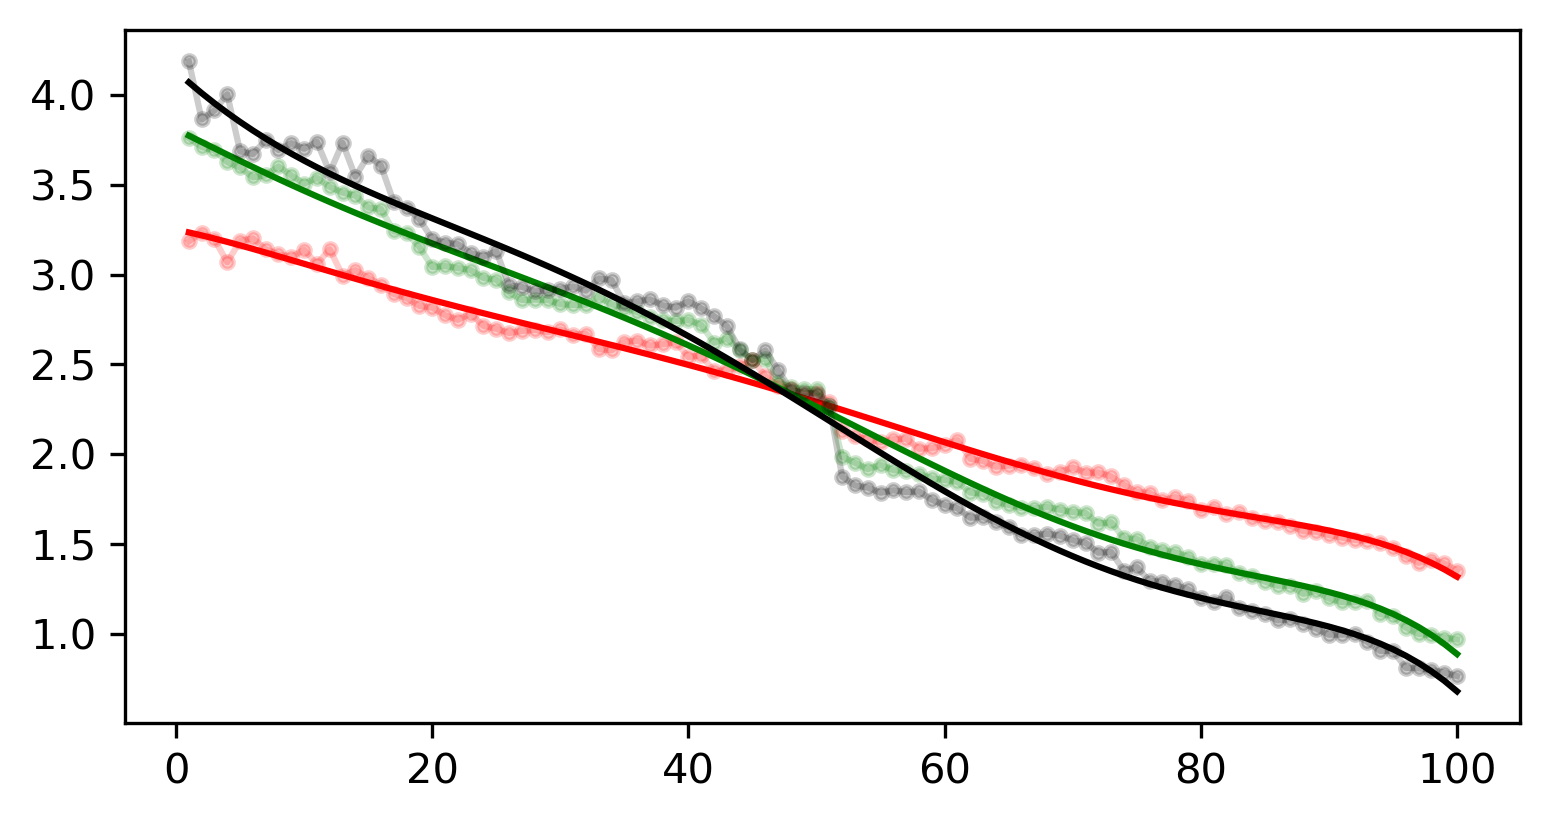

In [76]:
plt.figure(figsize=(6,3), dpi = 300)
# plt.ylim(0.5,4.5)
plt.plot(x, y,'r.-',alpha=0.2)
plt.plot(x, y_predicted, c="r")
plt.plot(x2, y2,'g.-',alpha=0.2)
plt.plot(x2, y_predicted2, c="g")
plt.plot(x3, y3,'k.-',alpha=0.2)
plt.plot(x3, y_predicted3, "k")

In [91]:
for u in range(1,140,3):
    print(u)

1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
82
85
88
91
94
97
100
103
106
109
112
115
118
121
124
127
130
133
136
139
